In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
# %matplotlib notebook

from multiprocessing import Pool
from scipy.signal import convolve
from datetime import datetime as dt 
import os
import glob

In [2]:
def make_salt_and_pepper(image, p,variable=False):
    # Pick random points in the image
    N = np.product(image.shape)
    
    indexes_salt = np.argwhere(np.random.binomial(1,p/2,image.shape))
    indexes_pepe = np.argwhere(np.random.binomial(1,p/2,image.shape))
    
    image_distorted = image.copy()
    if variable:
        image_distorted[indexes_salt[:,0],indexes_salt[:,1]] = np.random.random(len(indexes_salt))
        image_distorted[indexes_pepe[:,0],indexes_pepe[:,1]] = np.random.random(len(indexes_pepe))
    else:
        image_distorted[indexes_salt[:,0],indexes_salt[:,1]] = 1
        image_distorted[indexes_pepe[:,0],indexes_pepe[:,1]] = 0
    return image_distorted

def remove_hole(image,hole_size):
    h,w = image.shape
    hc,wc = h//2,w//2
    hs,ws = [x//2 for x in hole_size]
    mask = np.ones(image.shape)
    mask[hc-hs:hc+hs,wc-ws:wc+ws] = 0
    
    image_with_hole = image*mask
    return image_with_hole

In [3]:
def gaussian(winsize=3, sigma=3):
    t = sigma**2
    x = np.arange(-(winsize//2),winsize//2+1,1)
    filt = 1.0/np.sqrt(t*2.0*np.pi)*np.exp(-(x**2.0)/(2.0*t))
    return filt

def gaussian_1der(winsize=3, sigma=3):
    t = sigma**2
    x = np.arange(-(winsize//2),winsize//2+1,1)
    filt = (-x/t)*gaussian(winsize,sigma)
    return filt

In [4]:
def get_gaussian_mask(image,p=10):
    win_size = 3
    
    pixel_kernel = np.array([[1,1,1],[1,-8,1],[1,1,1]])
    convolved_test = np.abs(convolve(image,pixel_kernel,'same'))
    
    p_high = np.percentile(np.ravel(convolved_test),100-p)
    
    convolved_test_thresh = (convolved_test<p_high)
    
    return convolved_test_thresh*1. # very important to have 1. not 1, since otherwise visual won't work


def rolling_window(a, window):
    sh,sw = a.shape
    wh,ww = window
    
    shape = ((sh-wh+1), (sw-ww+1), wh, ww)
    strides = (a.strides[0], a.strides[1], a.strides[0], a.strides[1])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def filter_patches(patches,mask):
    wh,ww = patches.shape[-2:] 
    patches = patches.reshape((-1, wh*ww))
    
    mask_patches = rolling_window(mask,(wh,ww)).reshape((-1, wh*ww))
    
    patches = patches[np.argwhere(np.all(mask_patches != 0,axis=1))[:,0]].reshape(-1, wh, ww)
    return patches

def get_boundary_patches(mask,kernel_shape,corner_only=False):
    
    sh,sw = mask.shape
    wh,ww = kernel_shape 
    # coordinates of center pixel inside each patch
    p_row = int(kernel_shape[0]//2)
    p_col = int(kernel_shape[1]//2)
    
    mask_patches = rolling_window(mask,kernel_shape)
    
    # Find all patches of mask where center pixel is missing
    p_miss = np.argwhere(mask_patches[:,:,p_row,p_col] == 0)
    
    
    
    if corner_only:
        # Check how many zeros in each patch
        zero_counts = np.sum(mask_patches==0,(-1,-2))
        # Get the minimum number of missing neighbours where center is also missing
        min_val = np.min([zero_counts[row,col] for row,col in p_miss]) 
        indexes = np.argwhere((zero_counts <= min_val)*(mask_patches[:,:,p_row,p_col] == 0))
    else:
        
        # Count number of ones in distance 1 from center (i.e. right next to center)
        non_zero_counts = np.sum(mask_patches[:,:,
                                              p_row-1:p_row+2,
                                              p_col-1:p_col+2] == 1,(-1,-2))
        min_val = 3
        indexes = np.argwhere((non_zero_counts >= min_val)*(mask_patches[:,:,p_row,p_col] == 0))
  
    
    return indexes

def create_initial_mask(image):
    mask = np.zeros(image.shape)
    mask[np.where(image != 0)] = 1 
    return mask

def image_incomplete(mask,ox, oy):
    retval = (mask[ox:-ox,oy:-oy] != np.ones(mask[ox:-ox,oy:-oy].shape)).any()
    if retval:
        return retval
    else:
        print('Done!')
        return retval



def normalized_SSD(POI,patches,kernel_shape):
    '''
    Computes the normalized sum of squared differences between 
    the patch of interest (POI)
    and all other patches given   
    '''
    # width of kernel
    wh,ww = kernel_shape
    POI_shape = POI.shape
    feat_vecs = patches.reshape(-1,POI_shape[0])
    # mask for missing values
    POI_mask = (POI > 0)*1
    feat_vecs_mask = POI_mask * feat_vecs 
    
    
    # Scale the sigma to the size of the kernel
    sigma = (wh / 6)
    
    SD = (feat_vecs_mask - POI)**2
    SSD = np.sum(SD,axis=-1)
    
    # Normalize the SSD by the maximum possible contribution (based on missing pixels in POI mask)
    g2 = (gaussian(wh,sigma) * gaussian(wh,sigma).reshape(-1,1))
    total_SSD = np.sum(POI_mask * np.ravel(g2))
    
    normalized_ssd = SSD / total_SSD
    
    return normalized_ssd

def get_candidate_indices(normalized_ssd, error_threshold=0.3):
    min_ssd = np.min(normalized_ssd)
    min_threshold = min_ssd * (1. + error_threshold)
    indices = np.argwhere(normalized_ssd <= min_threshold)
    return indices

def softmax(x):
    s = np.exp(x - np.max(x,axis=0))  # shift values
    s = s / s.sum(axis=0)
    return s

def select_pixel_index(normalized_ssd, indices):
    N = len(indices)
    
    # increased weight for closest matches
    weights = softmax(-normalized_ssd[indices])
    # Select a random pixel index from the index list.
    selection = np.random.choice(np.arange(N), size=1, p=weights[:,0])
    selected_index = indices[selection]
    
    return selected_index

def get_pixel_value(index,POI_vec,filtered_patches,kernel_shape):
    
    p_row = int(kernel_shape[0]//2)
    p_col = int(kernel_shape[1]//2)
    selected_patch = filtered_patches[index].squeeze()
    pixel_value = selected_patch[p_row,p_col]
    return pixel_value
    

In [5]:
def synthesise_texture(image,kernel_shape,epsilon,
                       corner_only,noise_search=False,
                       verbose=0,noisep = 10,
                       save=False,filename='default'): 
    '''
    Ideas for improvement:
    - Use median of closest fits instead of a random sample
    - Sample with normal pdf around median
    
    '''
    
    if save:
        movie = []
        files = glob.glob(f'./saved/{filename}/*')
        for file in files:
            os.unlink(file)
            
    sh,sw = image.shape
    wh,ww = kernel_shape 
    
    if (wh % 2 == 0) | (ww % 2 == 0 ):
        print('Kernel has even lengths. using second closes odd lengths instead')
        kernel_shape = (wh,ww) = int(wh)//2+1,int(ww)//2+1
        
    # Offset for coordinates due to no-padding for boundaries (Maybe redundant except for plotting now)
    ox, oy = int(kernel_shape[1]//2),int(kernel_shape[0]//2)
    
    # Compute all patches in image
    patches_all = rolling_window(image,kernel_shape)
    
    # Create a mask 
    if noise_search:
        # With high derivatives
        mask = get_gaussian_mask(image,noisep)
    else:
        # with 0 values to keep track of missing pixels
        mask = create_initial_mask(image)
        
    print('mask shape:',mask.shape)
    
    # Filter out patches with missing pixel
    patches_filtered = filter_patches(patches_all,mask)
    
    if verbose > 0:
        print('patches_filtered:',patches_filtered.shape)
    last_time = dt.now()
    while image_incomplete(mask, ox, oy):
        
        # Fetch the center of all kernels with a single missing point
        # This will be points along the edges of the hole
        points_of_interest = get_boundary_patches(mask,kernel_shape,corner_only)
        for irow,icol in points_of_interest:
            if save:
                
                now = dt.now()
                diff = (now-last_time).total_seconds()
#                 print(diff)
                if diff > 0.25:
                    movie.append(image.copy())
                    plt.imsave('./saved/' + filename + '/' + filename + str(now.timestamp()) + '.png',image,cmap='gray')
                    last_time = now
                    #Visualize
#                     cv2.imshow('mask window', mask)
#                     cv2.imshow('synthesis window', image)

#                     key = cv2.waitKey(1) 
#                     if key == 27:
#                         cv2.destroyAllWindows()
#                         return image
            
#             else:
#                 #Visualize
#                 cv2.imshow('mask window', mask)
#                 cv2.imshow('synthesis window', image)

#                 key = cv2.waitKey(1) 
#                 if key == 27:
#                     cv2.destroyAllWindows()
#                     return image
            
            
            # Make feature vector
            feat_vec = np.ravel(patches_all[irow,icol])
            # Compute 
            n_ssd = normalized_SSD(feat_vec,patches_filtered,kernel_shape)
            
            # Get the indicies of patches that are close enough to point of interest
            candidate_indicies = get_candidate_indices(n_ssd,epsilon)
            
            # Select an index with some random chance
            selected_index = select_pixel_index(n_ssd, candidate_indicies)
            pixel_value = get_pixel_value(selected_index,feat_vec,patches_filtered,kernel_shape)
            
            mask[irow+ox,icol+oy] = 1
            image[irow+ox,icol+oy] = pixel_value
            
    movie.append(image.copy())
    cv2.destroyAllWindows()
    return image,movie

            




In [6]:
# Show data
img_full_1 = plt.imread('./texture_data/sample2train.png')
img_full_2 = plt.imread('./texture_data/sample1train.png')
img_full_2 = np.r_[np.c_[img_full_2,img_full_2],np.c_[img_full_2,img_full_2]][:150,:150] # Increase size for standard sizes
img_full_3 = (plt.imread('./texture_data/jungle.jpg')[300:450,300:450,0])/255+1/255

img_missing_1 = remove_hole(img_full_1,(50,50))
img_missing_2 = remove_hole(img_full_2,(50,50))
img_missing_3 = remove_hole(img_full_3,(50,50))


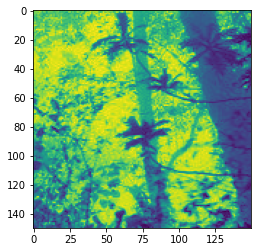

In [7]:
plt.imshow(img_full_3)

In [8]:
epsilon = 0.1
corner_only = True

kernel_shape = (3,3)
synthesized_image_1_3x3,image_1_3x3_movie = synthesise_texture(img_missing_1.copy(),kernel_shape,
                                             epsilon,corner_only,noise_search=False,
                                             verbose=1,save=True,filename = 'box_1_3x3')
synthesized_image_2_3x3,image_2_3x3_movie = synthesise_texture(img_missing_2.copy(),kernel_shape,
                                             epsilon,corner_only,noise_search=False,
                                             verbose=1,save=True,filename = 'box_2_3x3')
synthesized_image_3_3x3,image_3_3x3_movie = synthesise_texture(img_missing_3.copy(),kernel_shape,
                                             epsilon,corner_only,noise_search=False,
                                             verbose=1,save=True,filename = 'box_3_3x3')


kernel_shape = (15,15)
synthesized_image_1_15x15,age_1_15x15_movie = synthesise_texture(img_missing_1.copy(),kernel_shape,
                                               epsilon,corner_only,noise_search=False,
                                               verbose=1,save=True,filename = 'box_1_15x15')




mask shape: (150, 150)
patches_filtered: (19182, 3, 3)


KeyboardInterrupt: 

In [ ]:
synthesized_image_2_15x15,age_2_15x15_movie = synthesise_texture(img_missing_2.copy(),kernel_shape,
                                               epsilon,corner_only,noise_search=False,
                                               verbose=1,save=True,filename = 'box_2_15x15')
synthesized_image_3_15x15,age_3_15x15_movie = synthesise_texture(img_missing_3.copy(),kernel_shape,
                                               epsilon,corner_only,noise_search=False,
                                               verbose=1,save=True,filename = 'box_3_15x15')


In [ ]:
len(age_1_15x15_movie),len(image_1_3x3_movie)

In [9]:
for i in range(len(age_1_15x15_movie)):

    f,axes = plt.subplots(3,4,figsize=(15,10))
    axes = np.ravel(axes)
    titles = ['Original image',
            'Original image with hole',
            'Hole fixed with texture\nsynthesis (3x3) kernel',
            'Hole fixed with texture\nsynthesis (15x15) kernel'] + ['']*3*4

    images = [img_full_1,
            img_missing_1,
            image_1_3x3_movie[np.min([i,len(image_1_3x3_movie)-1])],
            age_1_15x15_movie[i],
            img_full_2,
            img_missing_2,
            image_2_3x3_movie[np.min([i,len(image_2_3x3_movie)-1])],
            age_2_15x15_movie[i],
            img_full_3,
            img_missing_3,
            image_3_3x3_movie[np.min([i,len(image_3_3x3_movie)-1])],
            age_3_15x15_movie[i],]

    for title,ax,img in zip(titles,axes,images):
        ax.imshow(img,vmin=0,vmax=1,cmap='gray')
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])


    plt.tight_layout(pad = 1, w_pad = -15)
    plt.savefig('./saved/all together/synthesis_movie_'+str(i)+'.png')
#     plt.show()

NameError: name 'age_1_15x15_movie' is not defined

NameError: name 'synthesized_image_1_3x3' is not defined

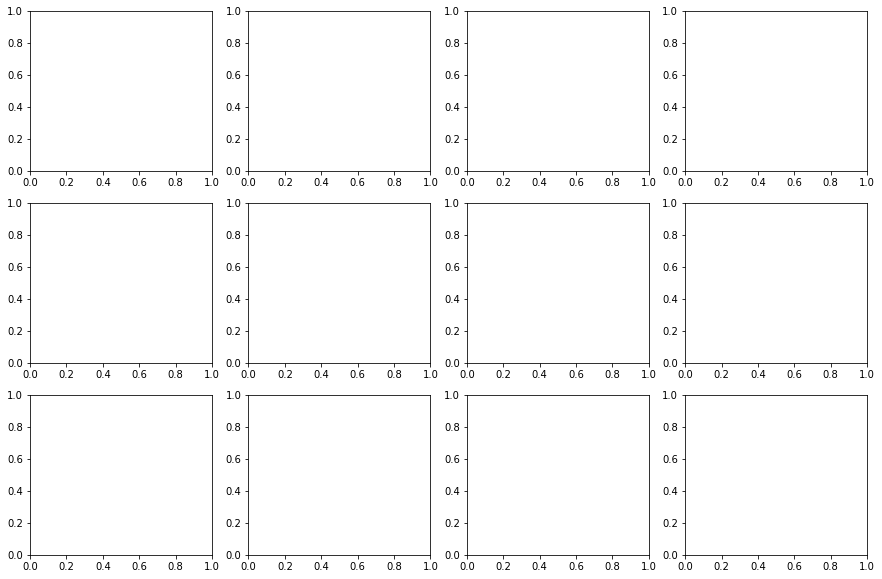

In [15]:
f,axes = plt.subplots(3,4,figsize=(15,10))
axes = np.ravel(axes)
titles = ['Original image',
          'Original image with hole',
          'Hole fixed with texture\nsynthesis (3x3) kernel',
          'Hole fixed with texture\nsynthesis (15x15) kernel'] + ['']*3*4

images = [img_full_1,
          img_missing_1,
          synthesized_image_1_3x3,
          synthesized_image_1_15x15,
          img_full_2,
          img_missing_2,
          synthesized_image_2_3x3,
          synthesized_image_2_15x15,
          img_full_3,
          img_missing_3,
          synthesized_image_3_3x3,
          synthesized_image_3_15x15]

for title,ax,img in zip(titles,axes,images):
    ax.imshow(img,vmin=0,vmax=1,cmap='gray')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout(pad = 1, w_pad = -15)
plt.show()

In [10]:

import cv2
lena_original = cv2.pyrDown(plt.imread('./texture_data/lena.png'))
lena_with_noise_10 = make_salt_and_pepper(lena_original,0.1)
lena_with_noise_20 = make_salt_and_pepper(lena_original,0.2)


In [11]:
kernel_shape = (3,3)
synthesized_lena_10_3x3,lena_10_3x3_movie = synthesise_texture(lena_with_noise_10.copy(),kernel_shape,
                                             epsilon,corner_only,noise_search=True,
                                             verbose=1,noisep=15,save=True,filename = 'lena_10_3x3')
synthesized_lena_20_3x3,lena_20_3x3_movie = synthesise_texture(lena_with_noise_20.copy(),kernel_shape,
                                             epsilon,corner_only,noise_search=True,
                                             verbose=1,noisep=30,save=True,filename = 'lena_20_3x3')



mask shape: (256, 256)
patches_filtered: (22664, 3, 3)
Done!
mask shape: (256, 256)
patches_filtered: (7190, 3, 3)
Done!


In [12]:
kernel_shape = (5,5)
synthesized_lena_10_5x5,lena_10_5x5_movie = synthesise_texture(lena_with_noise_10.copy(),kernel_shape,
                                             epsilon,corner_only,noise_search=True,
                                             verbose=1,noisep=15,save=True,filename = 'lena_10_5x5')
synthesized_lena_20_5x5,lena_20_5x5_movie = synthesise_texture(lena_with_noise_20.copy(),kernel_shape,
                                             epsilon,corner_only,noise_search=True,
                                             verbose=1,noisep=30,save=True,filename = 'lena_20_5x5')

mask shape: (256, 256)
patches_filtered: (3973, 5, 5)
Done!
mask shape: (256, 256)
patches_filtered: (243, 5, 5)
Done!


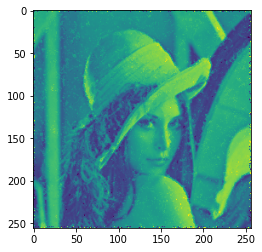

In [13]:
plt.imshow(synthesized_lena_20_5x5)

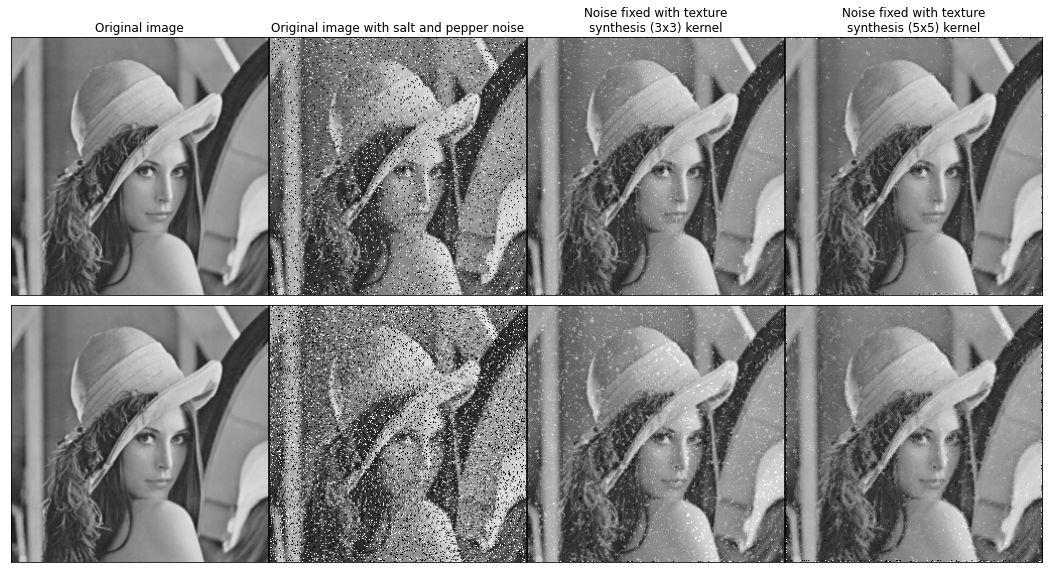

In [14]:
f,axes = plt.subplots(2,4,figsize=(16,8))
axes = np.ravel(axes)
titles = ['Original image',
          'Original image with salt and pepper noise',
          'Noise fixed with texture\nsynthesis (3x3) kernel',
          'Noise fixed with texture\nsynthesis (5x5) kernel'] + ['']*2*4

images = [lena_original,
          lena_with_noise_10,
          synthesized_lena_10_3x3,
          synthesized_lena_10_5x5,
          lena_original,
          lena_with_noise_20,
          synthesized_lena_20_3x3,
          synthesized_lena_20_5x5]
          
for title,ax,img in zip(titles,axes,images):
    ax.imshow(img,vmin=0,vmax=1,cmap='gray')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout(pad = 1, w_pad = -10)
plt.show()

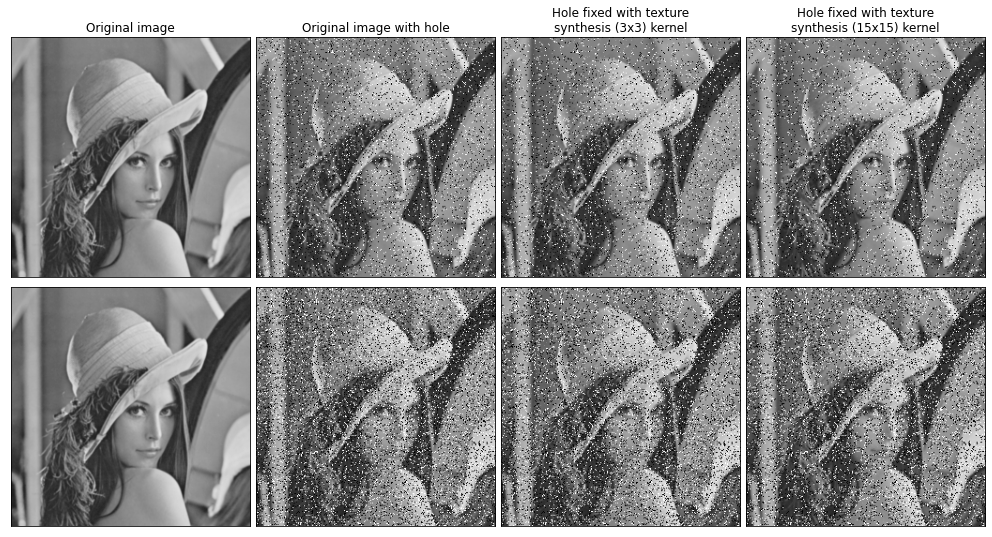

In [29]:
for i in range(len(lena_10_3x3_movie)):

    f,axes = plt.subplots(2,4,figsize=(15,7.5))
    axes = np.ravel(axes)
    titles = ['Original image',
            'Original image with hole',
            'Hole fixed with texture\nsynthesis (3x3) kernel',
            'Hole fixed with texture\nsynthesis (15x15) kernel'] + ['']*3*4

    images = [
        lena_original,
        lena_with_noise_10,
        lena_10_3x3_movie[np.min([i,len(lena_10_3x3_movie)-1])],
        lena_10_5x5_movie[i],
        lena_original,
        lena_with_noise_20,
        lena_20_3x3_movie[np.min([i,len(lena_20_3x3_movie)-1])],
        lena_20_5x5_movie[i]
    ]

    for title,ax,img in zip(titles,axes,images):
        ax.imshow(img,vmin=0,vmax=1,cmap='gray')
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])


    plt.tight_layout(pad = 1, w_pad = -8)
    plt.savefig('./saved/all together/synthesis_movie_lena_'+str(i)+'.png')
#     plt.show()
    plt.show()
    break

## Choose or construct a simple test example with repeated texture and a small hole and fill in the missing part.


## Choose a natural image and fill in a hole. Try varying number of patches, patch size, hole size, type of image, etc.

- Ideas for implementation

> apply the algorithm like normal but with a small kernel. 


> if noise is too much for generating kernels, then allow kernels to have missing pixels or update kernels when more are available


## Can the method be used for noise reduction? Experiment with e.g. salt and pepper noise.

- Ideas for an approach

> Instead of defining a missing pixel as pixels with value = 0, use pixels witha high gradient value (i.e. salt and peper noise)


> if noise is too much for generating kernels, then allow kernels to have missing pixels or update kernels when more are available


In [ ]:
import glob
import imageio

filenames = glob.glob('./saved/box_1_3x3/*')

numbers = [name[-20:-4] for name in filenames]
numbers = [float(num) for num in numbers]
name_sort = np.argsort(numbers)
# filenames = np.array(filenames)[name_sort]

In [ ]:
def images_to_gif(images,name):
    imageio.mimsave(f'./{name}.gif', [np.array(x*255).astype('uint8') for x in images])
    
movies = [image_1_3x3_movie,
          image_2_3x3_movie,
          image_3_3x3_movie,
          age_1_15x15_movie,
          age_2_15x15_movie,
          age_3_15x15_movie]

max_len = np.max([len(x) for x in movies])
min_len = np.min([len(x) for x in movies])

def make_waiting_gif(images,max_len,padding):
    last_frame = images[-1]
    len_start = len(images)
    images_extended = images + [last_frame for x in range(max_len-len_start + padding)]
    return images_extended
    
image_1_3x3_movie_padded = make_waiting_gif([x for x in image_1_3x3_movie + [synthesized_image_1_3x3]],max_len,100)
image_2_3x3_movie_padded = make_waiting_gif([x for x in image_2_3x3_movie + [synthesized_image_2_3x3]],max_len,100)
image_3_3x3_movie_padded = make_waiting_gif([x for x in image_3_3x3_movie + [synthesized_image_3_3x3]],max_len,100)
age_1_15x15_movie_padded = make_waiting_gif([x for x in age_1_15x15_movie][::4] + [synthesized_image_1_15x15],max_len,100)
age_2_15x15_movie_padded = make_waiting_gif([x for x in age_2_15x15_movie][::4] + [synthesized_image_2_15x15],max_len,100)
age_3_15x15_movie_padded = make_waiting_gif([x for x in age_3_15x15_movie][::4] + [synthesized_image_3_15x15],max_len,100)


images_to_gif(image_1_3x3_movie_padded,'image_1_3x3_movie')
images_to_gif(image_2_3x3_movie_padded,'image_2_3x3_movie')
images_to_gif(image_3_3x3_movie_padded,'image_3_3x3_movie')
images_to_gif(age_1_15x15_movie_padded,'image_1_15x15_movie')
images_to_gif(age_2_15x15_movie_padded,'image_2_15x15_movie')
images_to_gif(age_3_15x15_movie_padded,'image_3_15x15_movie')
# # images = []
# for filename in filenames:
#     images.append(imageio.imread(filename))


In [ ]:
lena_10_3x3_movie_pad = make_waiting_gif([x for x in lena_10_3x3_movie + [synthesized_lena_10_3x3]],max_len,100)
lena_10_5x5_movie_pad = make_waiting_gif([x for x in lena_10_5x5_movie + [synthesized_lena_10_5x5]],max_len,100)
lena_20_3x3_movie_pad = make_waiting_gif([x for x in lena_20_3x3_movie] + [synthesized_lena_20_3x3],max_len,100)
lena_20_5x5_movie_pad = make_waiting_gif([x for x in lena_20_5x5_movie] + [synthesized_lena_20_5x5],max_len,100)



images_to_gif(lena_10_3x3_movie_pad,'lena_10_3x3_movie_pad')
images_to_gif(lena_10_5x5_movie_pad,'lena_10_5x5_movie_pad')s
images_to_gif(lena_20_3x3_movie_pad,'lena_20_3x3_movie_pad')
images_to_gif(lena_20_5x5_movie_pad,'lena_20_5x5_movie_pad')